# **Hyperparameter Tuning**

### **Import Library dan Load Dataset**

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/day 32 parameter tuning/churn.csv')
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## **No 1. Data Cleaning**

### **Cek Missing Value**

In [88]:
df_info = df.info()
df_null_summary = df.isnull().sum()

df_info, df_null_summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


(None,
 customerID           9
 Gender              16
 SeniorCitizen       12
 Partner             16
 Dependents          19
 Tenure              17
 Contract            13
 PaperlessBilling    13
 PaymentMethod       11
 MonthlyCharges      10
 TotalCharges         0
 Churn                0
 dtype: int64)

### **Data Cleaning and Data Manipulation**

In [89]:
df_cleaned = df.dropna(subset=['customerID'])

# Fill missing values for categorical columns with mode (most frequent value)
categorical_cols = ['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Fill missing values for numerical columns with median
numerical_cols = ['SeniorCitizen', 'Tenure', 'MonthlyCharges']
for col in numerical_cols:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

# Remove duplicate rows based on 'customerID'
df_cleaned.drop_duplicates(subset=['customerID'], inplace=True)

# Verify the cleaned data
df_cleaned_info = df_cleaned.info()
df_cleaned_null_summary = df_cleaned.isnull().sum()
df_cleaned_info, df_cleaned_null_summary, df_cleaned.duplicated(subset=['customerID']).sum()

<class 'pandas.core.frame.DataFrame'>
Index: 7023 entries, 0 to 7031
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7023 non-null   object 
 1   Gender            7023 non-null   object 
 2   SeniorCitizen     7023 non-null   float64
 3   Partner           7023 non-null   object 
 4   Dependents        7023 non-null   object 
 5   Tenure            7023 non-null   float64
 6   Contract          7023 non-null   object 
 7   PaperlessBilling  7023 non-null   object 
 8   PaymentMethod     7023 non-null   object 
 9   MonthlyCharges    7023 non-null   float64
 10  TotalCharges      7023 non-null   float64
 11  Churn             7023 non-null   object 
dtypes: float64(4), object(8)
memory usage: 713.3+ KB


(None,
 customerID          0
 Gender              0
 SeniorCitizen       0
 Partner             0
 Dependents          0
 Tenure              0
 Contract            0
 PaperlessBilling    0
 PaymentMethod       0
 MonthlyCharges      0
 TotalCharges        0
 Churn               0
 dtype: int64,
 0)

## **2. Split Data**

In [90]:
from sklearn.model_selection import train_test_split

# Drop the 'customerID' column since it's not a relevant feature for modeling
df_cleaned = df_cleaned.drop(columns=['customerID'])

# Define features (X) and target (y)
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split the temp set into validation (50%) and testing (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Get the shape of the resulting sets
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(5618, 10), y=(5618,)
Validation set shape: X=(702, 10), y=(702,)
Testing set shape: X=(703, 10), y=(703,)


## **3. Features Selection and Multicollinearity**

Fitur dengan korelasi tinggi:
SeniorCitizen   TotalCharges    0.094357
Tenure          TotalCharges    0.826619
MonthlyCharges  TotalCharges    0.649933
dtype: float64


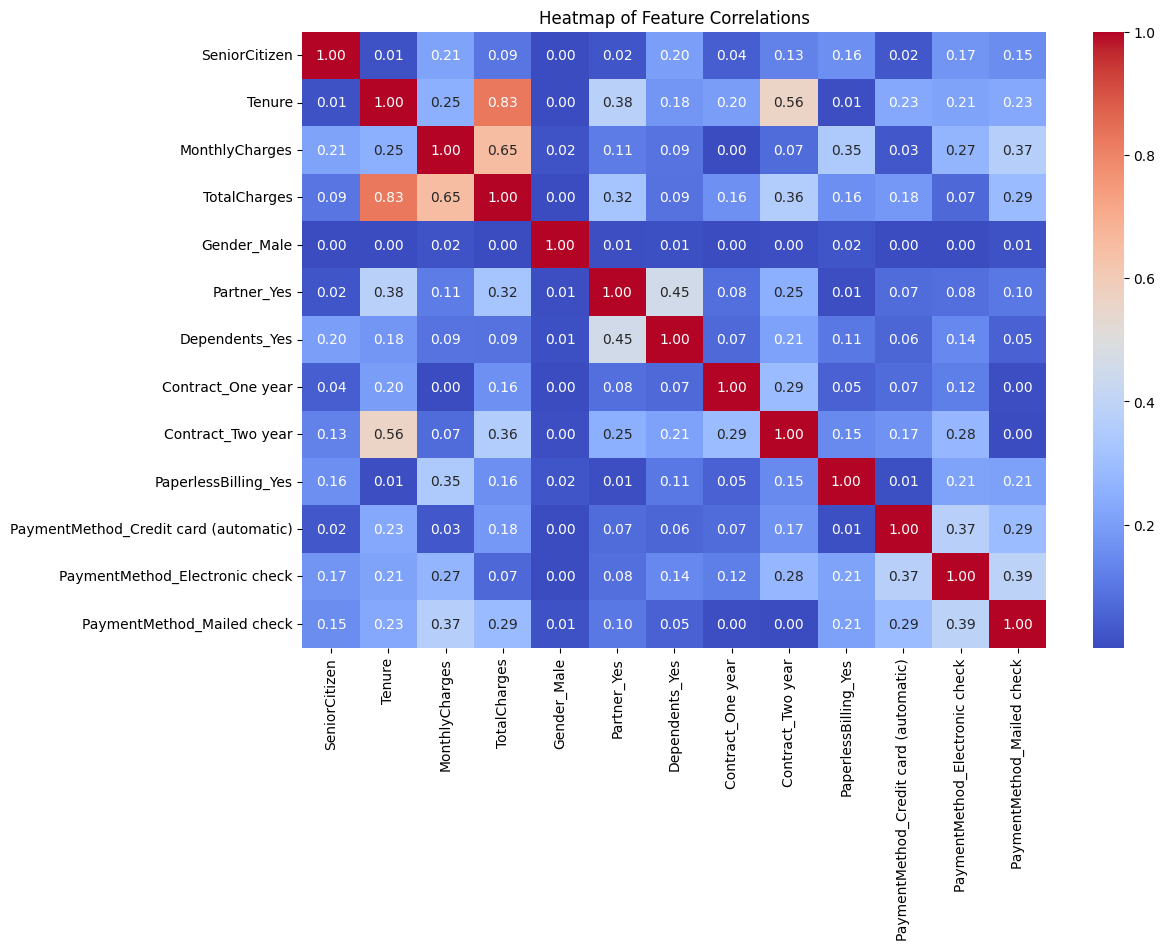

In [91]:
# One-hot encoding untuk kolom kategorikal
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)

# Pastikan kolom pada set pelatihan, validasi, dan pengujian konsisten
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Menghitung matriks korelasi pada set pelatihan
correlation_matrix = X_train_encoded.corr().abs()

# Identifikasi fitur dengan korelasi tinggi (>0.8), kecuali korelasi dengan diri sendiri
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Temukan fitur yang memiliki koefisien korelasi lebih besar dari 0.8
high_correlation_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

# Menampilkan fitur yang memiliki korelasi tinggi
print("Fitur dengan korelasi tinggi:")
print(upper_tri[high_correlation_features].stack())

# Hapus salah satu fitur yang berkorelasi tinggi
X_train_selected = X_train_encoded.drop(columns=high_correlation_features)
X_test_selected = X_test_encoded.drop(columns=high_correlation_features)
X_val_selected = X_val_encoded.drop(columns=high_correlation_features)

# Visualisasikan matriks korelasi dengan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Feature Correlations")
plt.show()

## **4. One Hot Encoding Catgorical Data**

In [92]:
df_cleaned_copy = df_cleaned.copy()

# Mengidentifikasi kolom dengan dua nilai berbeda (Biner)
binary_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']  # Contoh kolom, sesuaikan dengan dataset

# Mengonversi kolom biner menjadi nilai 0 dan 1
for col in binary_columns:
    df_cleaned_copy[col] = df_cleaned_copy[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# Menggunakan One-Hot Encoding untuk kolom kategorikal lainnya
categorical_columns = ['Contract', 'PaymentMethod']  # Contoh kolom, sesuaikan dengan dataset
df_final = pd.get_dummies(df_cleaned_copy, columns=categorical_columns, drop_first=True)

# Menampilkan beberapa baris pertama dari dataset yang telah diproses
df_final.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.0,0,0,1.0,1,29.85,29.85,0,False,False,False,True,False
1,1,0.0,0,0,34.0,0,56.95,1889.50,0,True,False,False,False,True
2,1,0.0,0,0,2.0,1,53.85,108.15,1,False,False,False,False,True
3,1,0.0,0,0,45.0,0,42.30,1840.75,0,True,False,False,False,False
4,0,0.0,0,0,2.0,1,70.70,151.65,1,False,False,False,True,False


## **5. Modelling**

### **Random Forest Classifier**

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

X = df_final.drop(columns=['Churn'])
y = df_final['Churn']

# Langkah Pembagian Data menjadi set Pelatihan, Validasi, dan Pengujian
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Menyusun grid hyperparameter
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cross Validation
# Inisialisasi GridSearchCV dengan set pelatihan dan validasi
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='f1')
grid_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Latih model terbaik pada set pelatihan + validasi
best_rf_model = grid_search.best_estimator_
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
best_rf_model.fit(X_combined, y_combined)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


RandomForestClassifier(max_depth=20, min_samples_split=10, random_state=42)

Hyperparameters Terbaik

**max_depth: 20:** Ini adalah kedalaman maksimum dari pohon keputusan. Kedalaman yang lebih besar bisa memungkinkan model belajar lebih banyak detail dari data, tetapi juga dapat menyebabkan overfitting.

**min_samples_leaf: 1:** Ini adalah jumlah minimum sampel yang harus ada di daun. Nilai 1 berarti bahwa setiap daun bisa memiliki satu sampel, yang bisa mengarah pada model yang kompleks dan rentan terhadap overfitting.

**min_samples_split: 10:** Ini adalah jumlah minimum sampel yang harus ada untuk membagi node. Nilai ini cukup tinggi, membantu mengurangi overfitting.

**n_estimators: 100:** Ini adalah jumlah pohon yang digunakan dalam ensemble model.

### **Evaluation and Matric**

In [94]:
# Evaluasi model pada set pengujian
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Tampilkan hasil evaluasi
print("\nTest Set Evaluation Metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("ROC-AUC: {:.2f}".format(roc_auc))




Test Set Evaluation Metrics:
Accuracy: 0.81
Precision: 0.67
Recall: 0.54
F1-Score: 0.60
ROC-AUC: 0.84


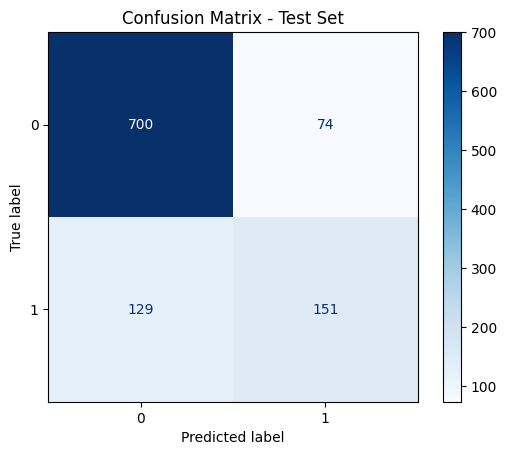


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       774
           1       0.67      0.54      0.60       280

    accuracy                           0.81      1054
   macro avg       0.76      0.72      0.74      1054
weighted avg       0.80      0.81      0.80      1054



In [95]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

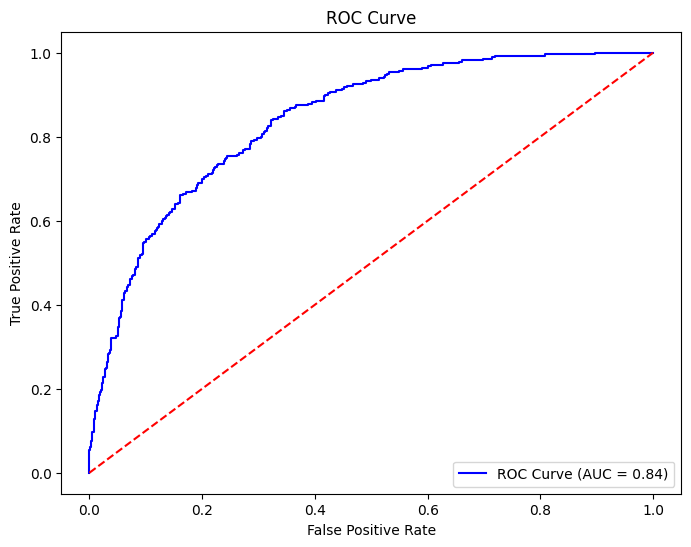

In [96]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc), color="blue")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Model memiliki akurasi yang cukup baik, tetapi ada ruang untuk meningkatkan recall dan precision, terutama untuk kelas positif. Ini bisa berarti bahwa model ini lebih baik dalam mengidentifikasi kelas negatif dibandingkan kelas positif.**